In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.2201629921242043
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.16599261319195782
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.15090871740270545
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.1131607868053295
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.10886835168909144


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.99481356 0.0013327  0.00385368]
[1. 0. 0.] <-> [0.9946353  0.0016993  0.00366538]
[0. 1. 0.] <-> [5.4521160e-03 9.9454319e-01 4.6096143e-06]
[1. 0. 0.] <-> [0.7022816  0.2970028  0.00071559]
[0. 0. 1.] <-> [3.744728e-02 8.378126e-05 9.624690e-01]
[1. 0. 0.] <-> [0.9907754  0.00811643 0.00110826]
[1. 0. 0.] <-> [0.99567324 0.0018544  0.00247243]
[1. 0. 0.] <-> [9.6319103e-01 3.5922304e-02 8.8659802e-04]
[1. 0. 0.] <-> [0.8468214  0.00135892 0.15181969]
[1. 0. 0.] <-> [0.5236091  0.47585237 0.00053848]
[1. 0. 0.] <-> [1.0921220e-01 2.3350384e-04 8.9055425e-01]
[0. 1. 0.] <-> [6.2516415e-03 9.9374300e-01 5.3377385e-06]
[1. 0. 0.] <-> [0.9953981  0.00131214 0.00328973]
[1. 0. 0.] <-> [0.99606687 0.00137032 0.00256285]
[1. 0. 0.] <-> [9.9715436e-01 1.8618521e-03 9.8378712e-04]
[1. 0. 0.] <-> [0.99723154 0.00126754 0.00150093]
[0. 0. 1.] <-> [7.2925282e-03 1.8076475e-05 9.9268943e-01]
[0. 1. 0.] <-> [1.5352395e-02 9.8463482e-01 1.2842516e-05]
[1. 0. 0.] <-> [9.9462765e-01 4

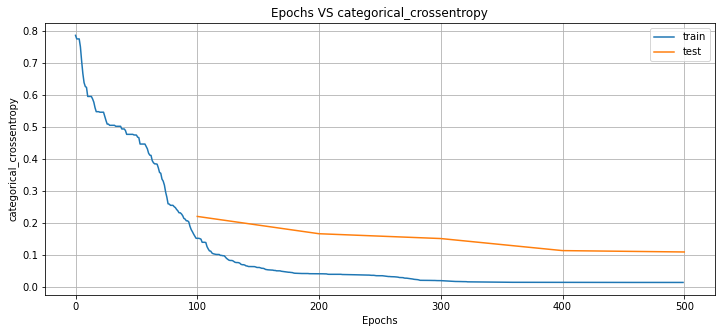

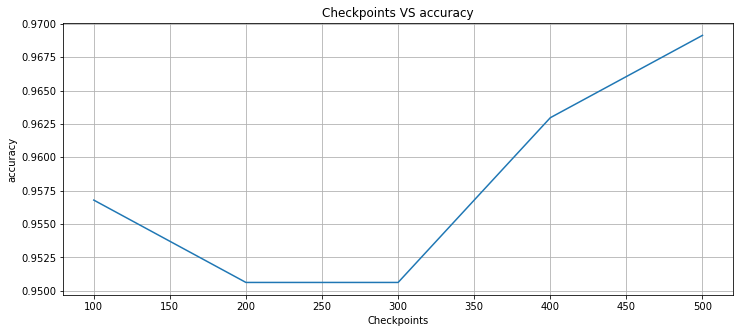

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9567901234567902, 'mean_square_error': 0.10613236605630227, 'categorical_crossentropy': 0.2201629921242043, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 5, 'tn_hit': 25, 'fn_hit': 2}, 1: {'tp_hit': 15, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.10467684477898027, 'categorical_crossentropy': 0.16599261319195782, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 4, 'tn_hit': 26, 'fn_hit': 4}, 1: {'tp_hit': 15, 'fp_hit': 3, 'tn_hit': 89, 'fn_hit': 1}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.0959781951501224, 'categorical_crossentropy': 0.15090871740270545, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 2, 'tn_hit': 28, 'fn_hit': 6}, 1: {'tp_hit': 16, 'fp_hit': 4, 'tn_hit': 88, 'fn_hit': 0}, 2: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 92, '

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.06914771 -3.         -0.44915628  1.045451    3.        ]
 bias: -2.569061517715454

Neuron 1: weights:
[-2.0712361   3.          3.         -2.3062344  -0.37396723]
 bias: -3.0

Neuron 2: weights:
[ 2.1765473 -3.        -3.        -1.2127618  1.8643708]
 bias: 2.745096206665039

Neuron 3: weights:
[ 0.13864844  3.         -0.32198077 -3.         -3.        ]
 bias: 1.784478783607483

$
Layer 2
Neuron 0: weights:
[-3. -3.  3.  3.]
 bias: 3.0

Neuron 1: weights:
[-3.        3.       -3.        2.210466]
 bias: 3.0

Neuron 2: weights:
[ 3. -3.  3. -3.]
 bias: 1.9136717319488525

$

